In [2]:
from ellipsx import calc_psi_delta_one_layer_vec, calc_psi_delta_one_layer_roughess_vec

In [3]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

In [4]:
import jax
import numpy as np
import jax.numpy as jnp

In [5]:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

In [6]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [7]:
import matplotlib.pyplot as plt

In [8]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True

In [9]:
%matplotlib inline

In [10]:
import optimistix as optx

In [11]:
from jaxtyping import Array, Complex, Float

# Подготовка данных

In [12]:
n = jnp.array([1., 1.462, 3.882 - 0.019j])
d = jnp.array([1., 400, 1])

In [13]:
phi = jnp.linspace(45, 80, 8)

In [15]:
psi, delta = calc_psi_delta_one_layer_vec(phi, n, d[1])
psi_rough, delta_rough = calc_psi_delta_one_layer_roughess_vec(phi, n, d)

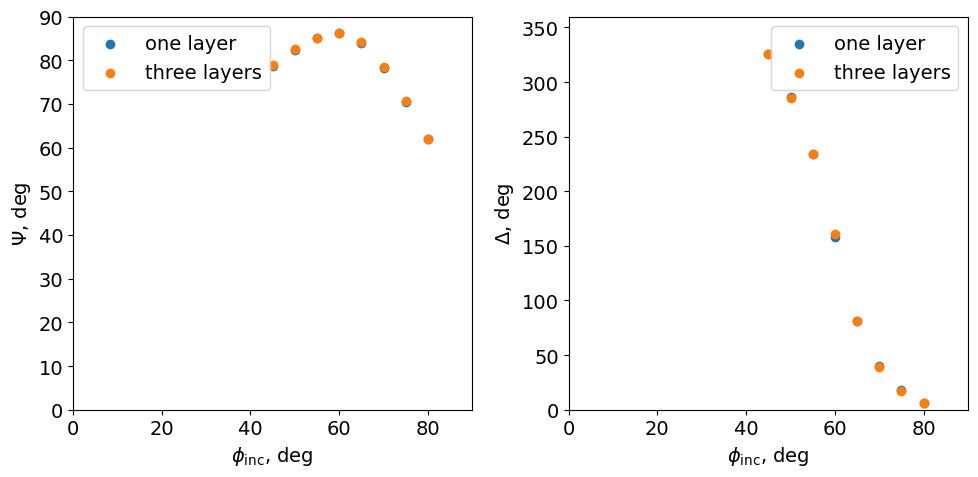

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(phi, psi, label='one layer')
ax1.scatter(phi, psi_rough, label='three layers')
ax2.scatter(phi, delta, label='one layer')
ax2.scatter(phi, delta_rough, label='three layers')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [17]:
from jax import random
key = random.key(0)
psi_std = 0.1
delta_std = 0.5

## One layer model

In [18]:
psi1 = psi + psi_std * random.normal(key, shape=psi.shape)
psi1_std = jnp.ones_like(psi1) * psi_std

In [19]:
delta1 = delta + delta_std * random.normal(key, shape=delta.shape)
delta1_std = jnp.ones_like(delta1) * delta_std

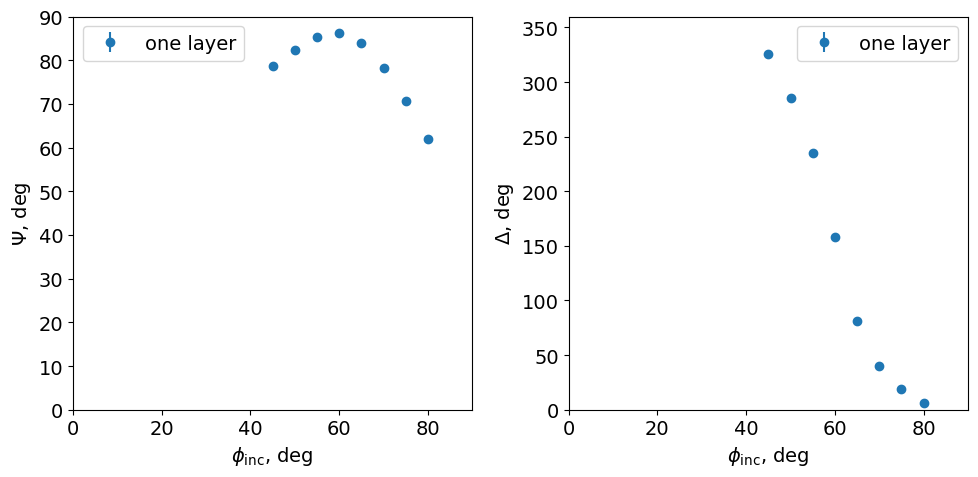

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='one layer', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='one layer', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [22]:
# Variable parameters are 1) oxide film thickness d_f, and 2) oxide refractive index n_f
# Other model parameters are fixed
@jax.jit
def residuals(params: Float[Array, "2"],  # d_f, n_f
              args: tuple[Float[Array, "5 len"],
                          Float[Array, "2"],  # n0
                          Float[Array, "2"],  # n_sub
                          Float]) -> Float[Array, "len + len"]:
    d_f = params[0]
    n_f = params[1] + 0j
    
    phi_psi_delta, n0, n_sub, wl = args
    
    phi = phi_psi_delta[0]
    psi_obs = phi_psi_delta[1]
    psi_std = phi_psi_delta[2]
    delta_obs = phi_psi_delta[3]
    delta_std = phi_psi_delta[4]

    n = jnp.array([n0[0] + 1j * n0[1], n_f, n_sub[0] + 1j * n_sub[1]])
    
    psi, delta = calc_psi_delta_one_layer_vec(phi, n, d_f, wl)
    return jnp.concatenate([(psi - psi_obs)/psi_std,
                           (delta - delta_obs)/delta_std])
    

In [23]:
params = jnp.array([400, 1.46])

In [24]:
args = (jnp.stack([phi, psi1, psi1_std, delta1, delta1_std]),
        jnp.array([1.0, 0]),
        jnp.array([3.882, - 0.019]),
        632.8)

In [26]:
residuals(params, args)

Array([  2.9511752 ,   2.66891642,  -1.02273775,  -1.50108827,
        -3.7768935 ,  -4.30631213,  -5.90229164,  -4.12978636,
        -5.188511  ,  -6.41010774, -11.91468003, -12.44169043,
        -6.10712268,  -2.88416679,  -3.46037231,  -1.89506323],      dtype=float64)

In [27]:
solver = optx.LevenbergMarquardt(rtol=1e-8, atol=1e-8)

In [28]:
sol = optx.least_squares(residuals, solver, params, args, max_steps=1024)

In [29]:
sol.value

Array([399.63505512,   1.46297354], dtype=float64)

In [30]:
phi_model = jnp.linspace(0, 90, 100)

In [34]:
n0 = args[1][0] + 1j * args[1][1]
n_f = sol.value[1] + 0j
n_sub = args[2][0] + 1j * args[2][1]

In [39]:
n = jnp.array([n0, n_f, n_sub])

In [40]:
d = sol.value[0]

In [41]:
wl = args[3]

In [43]:
psi, delta = calc_psi_delta_one_layer_vec(phi_model, n, d, wl)


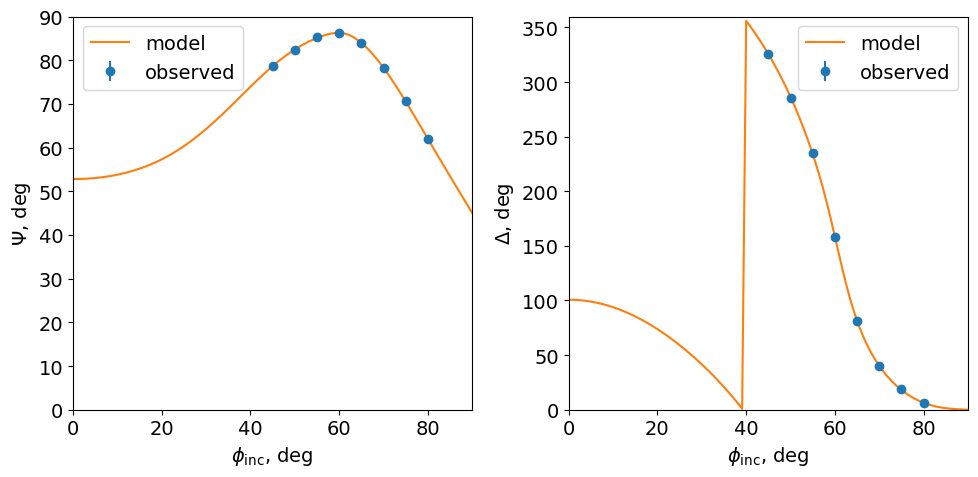

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [45]:
jac_res = jax.jacobian(residuals)(sol.value, args)

In [46]:
cov_matrix = jnp.linalg.inv(jac_res.T @ jac_res)

In [47]:
print(cov_matrix)

[[ 2.00513590e-01 -4.83570403e-04]
 [-4.83570403e-04  1.17457021e-06]]


In [48]:
std_params = jnp.sqrt(jnp.diag(cov_matrix))

In [49]:
sol.value, std_params

(Array([399.63505512,   1.46297354], dtype=float64),
 Array([0.44778744, 0.00108378], dtype=float64))

In [50]:
outer_v = np.outer(std_params, std_params)

In [51]:
cor_matrix = cov_matrix/outer_v

In [52]:
cor_matrix

Array([[ 1.        , -0.99643349],
       [-0.99643349,  1.        ]], dtype=float64)

## Three layer model

In [54]:
psi3 = psi_rough + psi_std * random.normal(key, shape=psi_rough.shape)
psi3_std = jnp.ones_like(psi_rough) * psi_std

In [55]:
delta3 = delta_rough + delta_std * random.normal(key, shape=delta_rough.shape)
delta3_std = jnp.ones_like(delta_rough) * delta_std

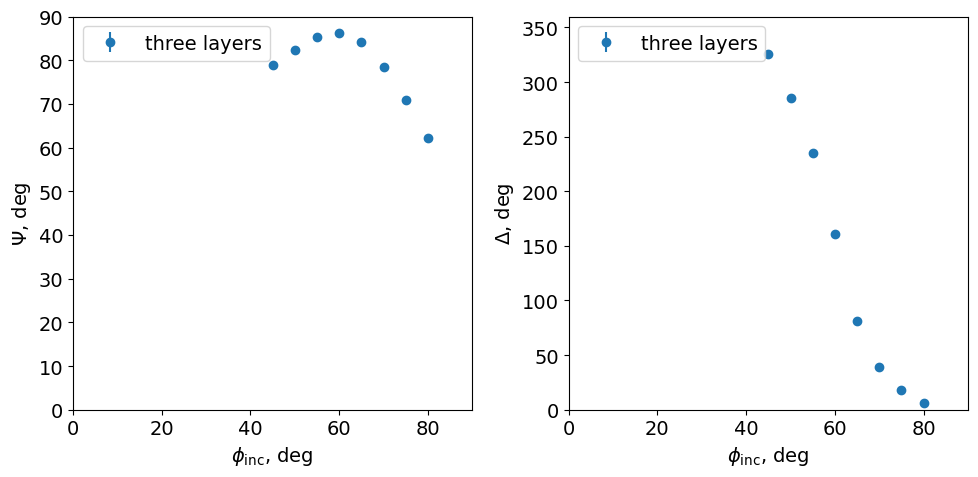

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='three layers', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='three layers', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [58]:
# Variable parameters are 1) oxide film thickness d_f, 2) oxide refractive index n_f,
# 3) interface width between air and oxide film d_0f, and 4) interface width between oxide film
# and substrate d_fs
# Other model parameters are fixed
@jax.jit
def residuals(params: Float[Array, "4"],  # d_f, n_f, d_0f, d_fs
              args: tuple[Float[Array, "5 len"],
                          Float[Array, "2"],  # n0
                          Float[Array, "2"],   # n_sub
                          Float]) -> Float[Array, "len + len"]:
    d_f = params[0]
    n_f = params[1] + 0j
    d_0f = params[2]
    d_fs = params[3]

    d = jnp.array([d_0f, d_f, d_fs])
    
    phi_psi_delta, n0, n_sub, wl = args
    
    phi = phi_psi_delta[0]
    psi_obs = phi_psi_delta[1]
    psi_std = phi_psi_delta[2]
    delta_obs = phi_psi_delta[3]
    delta_std = phi_psi_delta[4]

    n = jnp.array([n0[0] + 1j * n0[1], n_f, n_sub[0] + 1j * n_sub[1]])
    
    psi, delta = calc_psi_delta_one_layer_roughess_vec(phi, n, d, wl)
    return jnp.concatenate([(psi - psi_obs)/psi_std,
                           (delta - delta_obs)/delta_std])
    

In [59]:
params = jnp.array([400, 1.46, 4, 4])

In [60]:
args = (jnp.stack([phi, psi3, psi3_std, delta3, delta3_std]),
        jnp.array([1.0, 0]),
        jnp.array([3.882, - 0.019]),
        632.8)

In [61]:
residuals(params, args)

Array([  9.42123375,   3.71734097,  -4.98995895,  -2.00534723,
         4.50918668,   4.35995433,   0.42744391,  -0.36712743,
        -9.05643622, -15.63704808, -14.77153763,   4.9284113 ,
        -1.7813793 ,  -6.17389049,  -6.34403338,  -3.62076998],      dtype=float64)

In [62]:
solver = optx.LevenbergMarquardt(rtol=1e-8, atol=1e-8)

In [63]:
sol = optx.least_squares(residuals, solver, params, args, max_steps=1024)

In [64]:
sol.value

Array([3.99479408e+02, 1.46366634e+00, 1.53100188e-01, 1.12861068e+00],      dtype=float64)

In [65]:
phi_model = jnp.linspace(0, 90, 100)

In [66]:
n0 = args[1][0] + 1j * args[1][1]
n_f = sol.value[1] + 0j
n_sub = args[2][0] + 1j * args[2][1]

In [67]:
n = jnp.array([n0, n_f, n_sub])

In [69]:
d = jnp.array([sol.value[2], sol.value[0], sol.value[1]])

In [71]:
psi, delta = calc_psi_delta_one_layer_roughess_vec(phi_model, n, d)


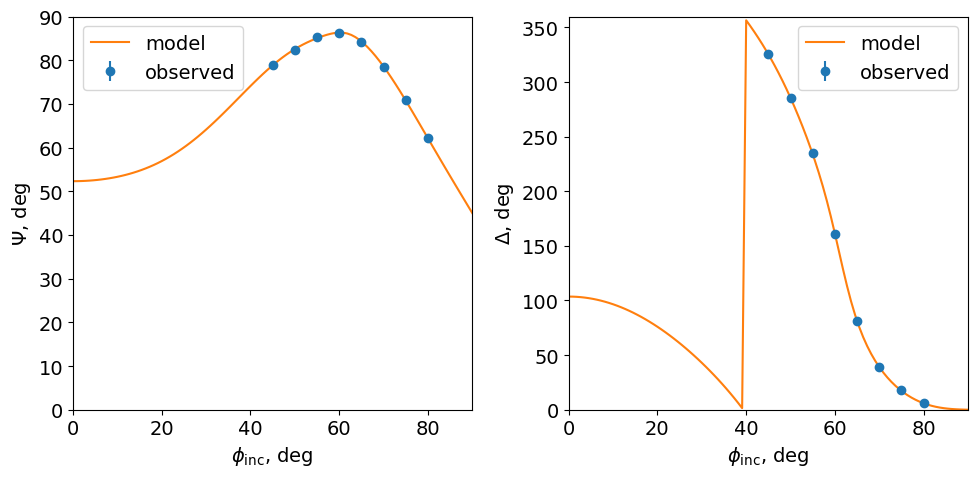

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [73]:
jac_res = jax.jacobian(residuals)(sol.value, args)

In [74]:
cov_matrix = jnp.linalg.inv(jac_res.T @ jac_res)

In [75]:
print(cov_matrix)

[[ 2.73415293e-01 -6.15750389e-04 -1.00383640e-01  9.90789155e-02]
 [-6.15750389e-04  1.58453246e-06 -2.53377202e-04 -4.21102186e-05]
 [-1.00383640e-01 -2.53377202e-04  1.24905670e+00 -4.90115927e-01]
 [ 9.90789155e-02 -4.21102186e-05 -4.90115927e-01  2.43217739e-01]]


In [76]:
std_params = jnp.sqrt(jnp.diag(cov_matrix))

In [77]:
sol.value, std_params

(Array([3.99479408e+02, 1.46366634e+00, 1.53100188e-01, 1.12861068e+00],      dtype=float64),
 Array([0.52289128, 0.00125878, 1.11761205, 0.4931711 ], dtype=float64))

In [78]:
outer_v = np.outer(std_params, std_params)

In [79]:
cor_matrix = cov_matrix/outer_v

In [80]:
cor_matrix

Array([[ 1.        , -0.9354977 , -0.1717752 ,  0.38421315],
       [-0.9354977 ,  1.        , -0.18010505, -0.06783273],
       [-0.1717752 , -0.18010505,  1.        , -0.88922183],
       [ 0.38421315, -0.06783273, -0.88922183,  1.        ]],      dtype=float64)